In [ ]:
!pip install opencv-python-headless mediapipe scikit-learn torch tqdm matplotlib

INFO: pip is looking at multiple versions of mediapipe to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.


In [ ]:
# Add this to your pip install cell
!apt-get install -y xvfb
!pip install pyvista

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import sys
import argparse
import json
import math
import glob
import random
from pathlib import Path
from collections import deque

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ML libs
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# MediaPipe (may need installation)
try:
    import mediapipe as mp
except Exception as e:
    mp = None
    print("mediapipe not installed. Install with `pip install mediapipe` to run pose extraction.")

In [ ]:


# ---------------------------
# Configuration (Tuned to your request)
# ---------------------------
CFG = {
    "drive_videos_dir": "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos",
    "output_dir": "/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs",
    "proc_fps": 4,
    "sample_videos": 15, # Process only 15 videos
    "use_pca": True,
    "pca_dims": 32,
    "n_keyframes": 25, # 25 K-Means clusters
    "random_seed": 42,
    "seq_len": 32,    # ST-GCN input length (frames)
    "pred_horizon": 1, # predict next frame (1)
    "batch_size": 8,
    "epochs": 10,
    "lr": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_path": "stgcn_regressor.pth"
}

# ---------------------------
# Utilities: MediaPipe pose
# ---------------------------
if 'mp' in globals() and mp is not None:
    mp_pose = mp.solutions.pose
    # POSE_DETECTOR initialization block
    POSE_DETECTOR = mp_pose.Pose(static_image_mode=False,
                                 model_complexity=1,
                                 enable_segmentation=False,
                                 min_detection_confidence=0.5,
                                 min_tracking_confidence=0.5)
else:
    POSE_DETECTOR = None

def sample_frames_from_video(video_path, sample_fps):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open {video_path}")
        return
    video_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    step = max(1, int(round(video_fps / sample_fps)))
    idx = 0
    with tqdm(total=total, desc=f"Sampling {os.path.basename(video_path)}") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if idx % step == 0:
                yield idx, idx / video_fps, frame
            idx += 1
            pbar.update(1)
    cap.release()

def extract_pose_landmarks(image_bgr):
    if POSE_DETECTOR is None:
        raise RuntimeError("MediaPipe not available.")
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = POSE_DETECTOR.process(img_rgb)
    if not results.pose_landmarks:
        return None
    landmarks = [[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
    return np.array(landmarks, dtype=np.float32)  # (33,3)

def normalize_landmarks(landmarks):
    if landmarks is None:
        return None
    # indices based on MediaPipe Pose:
    left_hip, right_hip = landmarks[23, :2], landmarks[24, :2]
    left_shoulder, right_shoulder = landmarks[11, :2], landmarks[12, :2]
    hip_mid = (left_hip + right_hip) / 2.0
    torso_mid = (left_shoulder + right_shoulder) / 2.0
    torso_len = np.linalg.norm(torso_mid - hip_mid)
    if torso_len < 1e-6: torso_len = 1e-6
    centered = landmarks.copy()
    centered[:,0] -= hip_mid[0]
    centered[:,1] -= hip_mid[1]
    normalized = (centered / torso_len).flatten()  # 99 dims
    return normalized

In [ ]:

# ---------------------------
# Keyframe extraction (PCA + K-Means)
# ---------------------------
# This function is used to identify key poses, but the full sequence is used for ST-GCN training.
def extract_keyframes_from_video(video_path, proc_fps=4, n_keyframes=25, use_pca=True, pca_dims=32):
    records = []
    # Re-samples frames just to collect pose vectors for clustering
    for f_idx, ts, frame in sample_frames_from_video(video_path, proc_fps):
        lm = extract_pose_landmarks(frame)
        if lm is None:
            continue
        vec99 = normalize_landmarks(lm)
        records.append({"frame_idx": int(f_idx), "timestamp": float(ts), "vec99": vec99, "frame": frame})
    if not records:
        return []
    X = np.stack([r["vec99"] for r in records], axis=0)

    # PCA
    if use_pca:
        n_comp = min(pca_dims, X.shape[1], X.shape[0])
        pca = PCA(n_components=n_comp, random_state=CFG["random_seed"])
        Xr = pca.fit_transform(X)
    else:
        Xr = X

    # K-Means
    n_clusters = min(n_keyframes, Xr.shape[0])
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=CFG["random_seed"], batch_size=256, n_init='auto')
    km.fit(Xr)

    # Find closest frame to each cluster center
    keyframe_indices = []
    for cid in range(n_clusters):
        members = np.where(km.labels_ == cid)[0]
        if len(members) == 0: continue
        center = km.cluster_centers_[cid]
        dists = np.linalg.norm(Xr[members] - center, axis=1)
        closest = members[np.argmin(dists)]
        keyframe_indices.append(int(closest))
    keyframe_indices = sorted(set(keyframe_indices))
    keyframes = [records[i] for i in keyframe_indices]
    return keyframes

# ---------------------------
# ST-GCN simplified model for regression (PyTorch)
# ---------------------------
class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size,1),
                              padding=(padding,0), stride=(stride,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        # x: (B, C, T, V)
        return self.act(self.bn(self.conv(x)))

class STBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.tconv = TemporalConv(in_channels, out_channels, kernel_size=kernel_size)
        # Spatial mixing is implicitly done here by a 1x1 convolution
        # as a stand-in for a Graph Convolution, which can be approximated this way
        # when the adjacency matrix is implicitly learned or fully connected (1x1 conv)
        self.sconv = nn.Conv2d(out_channels, out_channels, kernel_size=(1,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        # x shape: (B, C, T, V)
        x = self.tconv(x)    # temporal conv
        x = self.sconv(x)    # spatial mixing across joints (via 1x1 conv)
        x = self.bn(x)
        return self.act(x)

class STGCNRegressor(nn.Module):
    def __init__(self, in_channels=3, num_joints=33, seq_len=32, hidden_channels=[64,128,256]):
        super().__init__()
        # We'll treat input as (B, C, T, V) where C=3 (x,y,z), V=33 (joints)
        self.input_proj = nn.Conv2d(in_channels, hidden_channels[0], kernel_size=(1,1))
        self.blocks = nn.ModuleList()
        ch_in = hidden_channels[0]
        for h in hidden_channels:
            self.blocks.append(STBlock(ch_in, h))
            ch_in = h

        # Global pooling & final regressor to 3*num_joints (single-frame prediction)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(hidden_channels[-1], num_joints * 3)  # predict flattened 99 vector

    def forward(self, x):
        # x: (B, C=3, T, V=33)
        x = self.input_proj(x)  # (B, H0, T, V)
        for b in self.blocks:
            x = b(x)
        x = self.pool(x)  # (B, H, 1, 1)
        x = x.view(x.size(0), -1)  # (B, H)
        out = self.fc(x)  # (B, 99)
        return out

In [ ]:
# ---------------------------
# Dataset: prepare sequences of normalized vec99
# ---------------------------
class PoseSequenceDataset(Dataset):
    def __init__(self, sequences, seq_len=32, pred_horizon=1):
        # sequences: list of arrays shape (T, D) where D=99
        self.inputs = []
        self.targets = []
        for seq in sequences:
            T = seq.shape[0]
            # Slide window by 1
            for i in range(0, T - seq_len - pred_horizon + 1, 1):
                inp = seq[i: i + seq_len]  # (seq_len, 99)
                tgt = seq[i + seq_len + pred_horizon - 1]  # single target frame
                self.inputs.append(inp)
                self.targets.append(tgt)

        if len(self.inputs)==0:
            self.inputs = np.zeros((0, seq_len, 99), dtype=np.float32)
            self.targets = np.zeros((0, 99), dtype=np.float32)
        else:
            self.inputs = np.stack(self.inputs, axis=0).astype(np.float32)  # (N, seq_len, 99)
            self.targets = np.stack(self.targets, axis=0).astype(np.float32)  # (N, 99)
        self.seq_len = seq_len

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        inp = self.inputs[idx]  # (seq_len, 99)
        tgt = self.targets[idx]
        # reshape to (C=3, T, V=33) - required for ST-GCN input format
        inp = inp.reshape(self.seq_len, 33, 3).transpose(2,0,1)  # (3, T, V)
        return torch.from_numpy(inp), torch.from_numpy(tgt)

# ---------------------------
# Training / evaluation helpers
# ---------------------------
def euclidean_distance(a, b):
    # a,b are (N,99). Convert to (N, 33, 3) for joint distance.
    a = a.reshape(a.shape[0], 33, 3)
    b = b.reshape(b.shape[0], 33, 3)
    d = np.linalg.norm(a - b, axis=2)  # (N,33) per-joint distance
    return d.mean(axis=1)  # per-sample mean joint distance

def cosine_sim(a, b):
    # compute per-sample cosine between flattened vectors
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-8)
    return (a_norm * b_norm).sum(axis=1)  # per-sample cosine similarity

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cpu'):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {"train_loss": [], "val_loss": []}
    for ep in range(epochs):
        model.train()
        running = 0.0
        count = 0
        for xb, yb in tqdm(train_loader, desc=f"Epoch {ep+1} Training"):
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            count += xb.size(0)
        train_loss = running / max(1, count)

        val_loss = 0.0
        vcount = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in tqdm(val_loader, desc=f"Epoch {ep+1} Validation"):
                xb = xb.to(device); yb = yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                val_loss += loss.item() * xb.size(0)
                vcount += xb.size(0)
        val_loss = val_loss / max(1, vcount) if vcount>0 else 0.0

        history["train_loss"].append(train_loss); history["val_loss"].append(val_loss)
        print(f"Epoch {ep+1}/{epochs}  Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")
    return model, history

def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    preds = []
    gts = []
    with torch.no_grad():
        for xb, yb in tqdm(data_loader, desc="Evaluating"):
            xb = xb.to(device)
            out = model(xb).cpu().numpy()  # (B,99)
            preds.append(out); gts.append(yb.numpy())
    if len(preds)==0:
        return {"mse":0.0,"mean_euc":0.0,"mean_cos":0.0}, np.zeros((0,99)), np.zeros((0,99))
    preds = np.vstack(preds); gts = np.vstack(gts)
    mse = ((preds - gts) ** 2).mean()
    euc = euclidean_distance(preds, gts).mean()
    cos = cosine_sim(preds, gts).mean()
    return {"mse": float(mse), "mean_euc": float(euc), "mean_cos": float(cos)}, preds, gts

In [ ]:

# ---------------------------
# Simple stickman plot utility
# ---------------------------
# MediaPipe Pose connections
MP_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8), # Head/Face
    (9,10),(11,12),(11,13),(13,15),(12,14),(14,16), # Arms
    (23,24),(11,23),(12,24),(23,25),(24,26),(25,27),(26,28) # Torso/Legs
]
def plot_stickman(ax, vec99, title="pose"):
    arr = vec99.reshape(33,3)
    xs = arr[:,0]; ys = -arr[:,1]  # invert y for standard plot orientation
    ax.scatter(xs, ys, s=10)
    for a,b in MP_CONNECTIONS:
        if a < 33 and b < 33:
            ax.plot([xs[a], xs[b]], [ys[a], ys[b]], linewidth=2, marker='o', markersize=3)
    ax.set_title(title); ax.axis('equal'); ax.axis('off')

import pyvista as pv

# Start the virtual framebuffer for Colab rendering
pv.start_xvfb()

In [ ]:
# ---------------------------
# 3D Mannequin Plot Utility (PyVista)
# ---------------------------
# MediaPipe Pose connections (Same as before)
MP_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,7),(0,4),(4,5),(5,6),(6,8), # Head/Face
    (9,10),(11,12),(11,13),(13,15),(12,14),(14,16), # Arms
    (23,24),(11,23),(12,24),(23,25),(24,26),(25,27),(26,28) # Torso/Legs
]

def plot_3d_mannequin(vec99, filename="pose.png"):
    """
    Renders a 33-keypoint pose vector as a 3D mannequin using PyVista.
    """
    # Reshape data to (33, 3)
    landmarks = vec99.reshape(33, 3).copy()

    # Invert Y-axis so the character stands upright (matching image coordinates)
    landmarks[:, 1] = -landmarks[:, 1]

    # Create a plotter (off_screen=True is required for Colab/Servers)
    p = pv.Plotter(off_screen=True, window_size=[800, 800])
    p.set_background("white")  # Clean background for reports

    # 1. Draw Limbs (Tubes)
    for a, b in MP_CONNECTIONS:
        if a < 33 and b < 33:
            point_a = landmarks[a]
            point_b = landmarks[b]

            # Draw a line between joints
            line = pv.Line(point_a, point_b)
            # Wrap line in a tube to give it 3D volume (like a limb)
            tube = line.tube(radius=0.025)
            p.add_mesh(tube, color="#E0AC69", smooth_shading=True) # "Tan" skin tone color

    # 2. Draw Joints (Spheres)
    for point in landmarks:
        sphere = pv.Sphere(radius=0.035, center=point)
        p.add_mesh(sphere, color="#FF5555", smooth_shading=True) # Red joints

    # Camera setup (Front view)
    p.view_xy()
    p.camera.zoom(1.2)

    # Save and close
    p.show(screenshot=filename)
    p.close()
    print(f"Saved 3D visualization to {filename}")





/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [1]:
# ---------------------------
# Main workflow
# ---------------------------
def main(args):
    # Setup
    random.seed(CFG["random_seed"]); np.random.seed(CFG["random_seed"]); torch.manual_seed(CFG["random_seed"])
    out_dir = Path(args.output_dir or CFG["output_dir"]); out_dir.mkdir(parents=True, exist_ok=True)
    drive_dir = Path(args.drive_path or CFG["drive_videos_dir"])

    # Locate and filter videos
    vpaths = sorted(glob.glob(str(drive_dir / "*.*")))
    vpaths = [p for p in vpaths if p.lower().endswith(('.mp4','.mov','.avi','.mkv','.webm'))]
    if not vpaths:
        print("No video files found in the specified drive directory:", drive_dir)
        return

    # Limit videos to process
    vpaths = vpaths[: args.n_videos or CFG["sample_videos"]]
    print(f"Found {len(vpaths)} eligible videos. Processing {len(vpaths)} videos...")

    # Step A: Extract pose sequences (99-dim vectors per sampled frame)
    sequences = []
    for vp in vpaths:
        print("\nProcessing:", vp)
        # Run keyframe extraction for stability/generalization analysis (not used for ST-GCN input)
        kfs = extract_keyframes_from_video(vp, proc_fps=CFG["proc_fps"], n_keyframes=CFG["n_keyframes"],
                                         use_pca=CFG["use_pca"], pca_dims=CFG["pca_dims"])
        print(f"Extracted {len(kfs)} keyframes from {os.path.basename(vp)}")

        # Collect the full sequence for ST-GCN training
        frames_vecs = []
        for f_idx, ts, frame in sample_frames_from_video(vp, CFG["proc_fps"]):
            lm = extract_pose_landmarks(frame)
            if lm is None: continue
            frames_vecs.append(normalize_landmarks(lm))

        if len(frames_vecs) >= CFG["seq_len"] + CFG["pred_horizon"]:
            seq_arr = np.stack(frames_vecs, axis=0)
            sequences.append(seq_arr)
        else:
            print(f"Skipping {vp} because not enough pose frames ({len(frames_vecs)}) for sequence length {CFG['seq_len']}")

    if not sequences:
        print("No sequences available for training after processing videos.")
        return

    # Split into train/val (80/20)
    random.shuffle(sequences)
    n_train = int(0.8 * len(sequences))
    train_seqs = sequences[:n_train]; val_seqs = sequences[n_train:]
    train_ds = PoseSequenceDataset(train_seqs, seq_len=CFG["seq_len"], pred_horizon=CFG["pred_horizon"])
    val_ds = PoseSequenceDataset(val_seqs, seq_len=CFG["seq_len"], pred_horizon=CFG["pred_horizon"])
    print(f"Total sequences processed: {len(sequences)}")
    print(f"Train samples: {len(train_ds)}  Val samples: {len(val_ds)}")

    train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False)

    # Build model
    model = STGCNRegressor(in_channels=3, num_joints=33, seq_len=CFG["seq_len"], hidden_channels=[64,128,256])
    print(f"Model built. Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train
    model, history = train_model(model, train_loader, val_loader, epochs=args.epochs or CFG["epochs"],
                                 lr=args.lr or CFG["lr"], device=CFG["device"])

    # Plot training history (Graph)
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(history["train_loss"], label="Train Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (MSE)"); ax.legend(); ax.set_title("Training Loss History")
    plt.tight_layout()
    plt.savefig(out_dir / "training_loss.png")
    print("Saved training loss plot to", out_dir / "training_loss.png")



    # -------------------------------------------------------
    # 2. Save Model (Your provided code with directory fix)
    # -------------------------------------------------------
    save_dir = out_dir
    filename = "kmeans_stgcnn.pth"

    save_path = save_dir / filename
    torch.save({
        "model_state": model.state_dict(),
        "cfg": CFG,
    }, str(save_path))

    print(f"\n✅ Model successfully saved to: {save_path}")

    """
    # Evaluate on validation set (Performance Metrics)
    metrics, preds, gts = evaluate_model(model, val_loader, device=CFG["device"])
    print("\n--- Final Validation Metrics ---")
    print(json.dumps(metrics, indent=2))

    # Plot training history (Graph)
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(history["train_loss"], label="Train Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss (MSE)"); ax.legend(); ax.set_title("Training Loss History")
    plt.tight_layout()
    plt.savefig(out_dir / "training_loss.png")
    print("Saved training loss plot to", out_dir / "training_loss.png")

    # Pick one sample and plot stickman predicted vs ground truth (Predict Pose & Plot)
    if len(val_ds)>0:
        sample_inp, sample_gt = val_ds[0]
        model.eval()
        with torch.no_grad():
            inp = sample_inp.unsqueeze(0).to(CFG["device"])
            pred = model(inp).cpu().numpy()[0]

        fig, axes = plt.subplots(1,2, figsize=(8,4))
        plot_stickman(axes[0], sample_gt.numpy(), title="Ground Truth Pose (t+1)")
        plot_stickman(axes[1], pred, title="Predicted Pose (t+1)")



        input_last_frame = sample_inp.permute(1, 2, 0).numpy()[-1].flatten() # (T, V, C) -> (V, C) -> (99)
        fig_inp, ax_inp = plt.subplots(1,1, figsize=(4,4))
        plot_stickman(ax_inp, input_last_frame, title="Input Sequence Final Frame (t)")
        fig_inp.tight_layout()
        fig_inp.savefig(out_dir / "input_pose.png")
        print("Saved input pose context to", out_dir / "input_pose.png")

        plt.tight_layout()
        plt.savefig(out_dir / "pred_vs_gt_stickman.png")
        print("Saved predicted vs gt stickman to", out_dir / "pred_vs_gt_stickman.png")
    else:
        print("No validation samples to visualize.")

    if len(val_ds) > 0:
      sample_inp, sample_gt = val_ds[0]


      model.eval()
      with torch.no_grad():
        inp = sample_inp.unsqueeze(0).to(CFG["device"])
        pred = model(inp).cpu().numpy()[0]

        gt_pose = sample_gt.numpy()

        gt_filename = str(out_dir / "ground_truth_3d.png")
        plot_3d_mannequin(gt_pose, filename=gt_filename)


        pred_filename = str(out_dir / "predicted_3d.png")
        plot_3d_mannequin(pred, filename=pred_filename)

      try:
        from IPython.display import Image, display
        print("\n--- Ground Truth (Left) vs Prediction (Right) ---")
        display(Image(gt_filename, width=300))
        display(Image(pred_filename, width=300))
      except ImportError:
          pass
      else:
          print("No validation samples to visualize.")

 """

In [ ]:
# -------------------------------------------------------
#  LOAD Model (The part you asked for)
# -------------------------------------------------------
save_path = "/content/dance_outputs/YYYY-MM-DD/HH-MM-SS/kmeans_stgcnn.pth"

# Re-initialize a fresh model to ensure we aren't using the in-memory one
loaded_model = STGCNRegressor(in_channels=3, num_joints=33, seq_len=CFG["seq_len"], hidden_channels=[64,128,256])

# Load the checkpoint
# map_location ensures it loads to the correct device (CPU/GPU) even if saved on a different one
checkpoint = torch.load(str(save_path), map_location=CFG["device"])

# Load weights
loaded_model.load_state_dict(checkpoint['model_state'])

# Send to device and set to eval mode
loaded_model.to(CFG["device"])
loaded_model.eval()

# REPLACE the variable 'model' with 'loaded_model'
# Now all subsequent functions (evaluate, plot) will use the loaded version
model = loaded_model


metrics, preds, gts = evaluate_model(model, val_loader, device=CFG["device"])
print("\n--- Final Validation Metrics ---")
print(json.dumps(metrics, indent=2))

# Pick one sample and plot stickman predicted vs ground truth (Predict Pose & Plot)
if len(val_ds)>0:
  sample_inp, sample_gt = val_ds[0]
  model.eval()
  with torch.no_grad():
    inp = sample_inp.unsqueeze(0).to(CFG["device"])
    pred = model(inp).cpu().numpy()[0]

    fig, axes = plt.subplots(1,2, figsize=(8,4))
    plot_stickman(axes[0], sample_gt.numpy(), title="Ground Truth Pose (t+1)")
    plot_stickman(axes[1], pred, title="Predicted Pose (t+1)")



    input_last_frame = sample_inp.permute(1, 2, 0).numpy()[-1].flatten() # (T, V, C) -> (V, C) -> (99)
    fig_inp, ax_inp = plt.subplots(1,1, figsize=(4,4))
    plot_stickman(ax_inp, input_last_frame, title="Input Sequence Final Frame (t)")
    fig_inp.tight_layout()
    fig_inp.savefig(out_dir / "input_pose.png")
    print("Saved input pose context to", out_dir / "input_pose.png")

    plt.tight_layout()
    plt.show()
    # plt.savefig(out_dir / "pred_vs_gt_stickman.png")
else:
    print("No validation samples to visualize.")




Starting ST-GCN Dance Pose Prediction Pipeline (Colab Mode)...
Found 15 eligible videos. Processing 15 videos...

Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/DhalankuAdavu1.mp4


Sampling DhalankuAdavu1.mp4:   0%|          | 0/3725 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling DhalankuAdavu1.mp4: 100%|██████████| 3725/3725 [00:55<00:00, 66.69it/s]


Extracted 25 keyframes from DhalankuAdavu1.mp4


Sampling DhalankuAdavu1.mp4:   0%|          | 0/3725 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling DhalankuAdavu1.mp4: 100%|██████████| 3725/3725 [00:53<00:00, 69.20it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/DhalankuAdavu2.mp4


Sampling DhalankuAdavu2.mp4: 100%|██████████| 3773/3773 [00:54<00:00, 69.58it/s]


Extracted 25 keyframes from DhalankuAdavu2.mp4


Sampling DhalankuAdavu2.mp4:   0%|          | 0/3773 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling DhalankuAdavu2.mp4: 100%|██████████| 3773/3773 [00:54<00:00, 69.54it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Karthari Adavu _ Kalakshetra Style.mp4


Sampling Karthari Adavu _ Kalakshetra Style.mp4: 100%|██████████| 2237/2237 [00:25<00:00, 86.94it/s] 


Extracted 25 keyframes from Karthari Adavu _ Kalakshetra Style.mp4


Sampling Karthari Adavu _ Kalakshetra Style.mp4:   0%|          | 0/2237 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Karthari Adavu _ Kalakshetra Style.mp4: 100%|██████████| 2237/2237 [00:25<00:00, 88.00it/s] 



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KarthariAdavu.mp4


Sampling KarthariAdavu.mp4: 100%|██████████| 2160/2160 [00:25<00:00, 83.32it/s]


Extracted 25 keyframes from KarthariAdavu.mp4


Sampling KarthariAdavu.mp4:   0%|          | 5/2160 [00:00<00:44, 47.91it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KarthariAdavu.mp4: 100%|██████████| 2160/2160 [00:25<00:00, 84.67it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Karthariadavu1.mp4


Sampling Karthariadavu1.mp4: 100%|██████████| 2775/2775 [00:35<00:00, 77.50it/s]


Extracted 25 keyframes from Karthariadavu1.mp4


Sampling Karthariadavu1.mp4:   0%|          | 11/2775 [00:00<00:52, 52.19it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Karthariadavu1.mp4: 100%|██████████| 2775/2775 [00:34<00:00, 80.63it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KattiAdavu.mp4


Sampling KattiAdavu.mp4: 100%|██████████| 2825/2825 [00:36<00:00, 76.68it/s]


Extracted 25 keyframes from KattiAdavu.mp4


Sampling KattiAdavu.mp4:   0%|          | 0/2825 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KattiAdavu.mp4: 100%|██████████| 2825/2825 [00:36<00:00, 76.88it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Korvai Adavu2.1.mp4


Sampling Korvai Adavu2.1.mp4: 100%|██████████| 2700/2700 [00:30<00:00, 89.68it/s] 


Extracted 25 keyframes from Korvai Adavu2.1.mp4


Sampling Korvai Adavu2.1.mp4:   0%|          | 0/2700 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Korvai Adavu2.1.mp4: 100%|██████████| 2700/2700 [00:29<00:00, 90.87it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Korvai Adavu2.2.mp4


Sampling Korvai Adavu2.2.mp4: 100%|██████████| 2340/2340 [00:26<00:00, 89.60it/s]


Extracted 25 keyframes from Korvai Adavu2.2.mp4


Sampling Korvai Adavu2.2.mp4:   0%|          | 0/2340 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Korvai Adavu2.2.mp4: 100%|██████████| 2340/2340 [00:25<00:00, 90.71it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Korvai Adavu2.3.mp4


Sampling Korvai Adavu2.3.mp4: 100%|██████████| 2730/2730 [00:30<00:00, 90.81it/s]


Extracted 25 keyframes from Korvai Adavu2.3.mp4


Sampling Korvai Adavu2.3.mp4:   0%|          | 0/2730 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Korvai Adavu2.3.mp4: 100%|██████████| 2730/2730 [00:30<00:00, 89.58it/s] 



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/Korvai Adavu2.4.mp4


Sampling Korvai Adavu2.4.mp4: 100%|██████████| 2730/2730 [00:31<00:00, 87.27it/s] 


Extracted 25 keyframes from Korvai Adavu2.4.mp4


Sampling Korvai Adavu2.4.mp4:   0%|          | 0/2730 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling Korvai Adavu2.4.mp4: 100%|██████████| 2730/2730 [00:31<00:00, 86.45it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu1.mp4


Sampling KorvaiAdavu1.mp4: 100%|██████████| 7733/7733 [01:12<00:00, 106.44it/s]


Extracted 25 keyframes from KorvaiAdavu1.mp4


Sampling KorvaiAdavu1.mp4:   0%|          | 0/7733 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu1.mp4: 100%|██████████| 7733/7733 [01:11<00:00, 107.86it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu2.mp4


Sampling KorvaiAdavu2.mp4: 100%|██████████| 8032/8032 [01:18<00:00, 102.16it/s]


Extracted 25 keyframes from KorvaiAdavu2.mp4


Sampling KorvaiAdavu2.mp4:   0%|          | 0/8032 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu2.mp4: 100%|██████████| 8032/8032 [01:16<00:00, 104.53it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu3.mp4


Sampling KorvaiAdavu3.mp4: 100%|██████████| 7792/7792 [01:13<00:00, 105.32it/s]


Extracted 25 keyframes from KorvaiAdavu3.mp4


Sampling KorvaiAdavu3.mp4:   0%|          | 0/7792 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu3.mp4: 100%|██████████| 7792/7792 [01:12<00:00, 107.39it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu4.mp4


Sampling KorvaiAdavu4.mp4: 100%|██████████| 7312/7312 [01:08<00:00, 107.42it/s]


Extracted 25 keyframes from KorvaiAdavu4.mp4


Sampling KorvaiAdavu4.mp4:   0%|          | 28/7312 [00:00<00:52, 138.26it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu4.mp4: 100%|██████████| 7312/7312 [01:07<00:00, 109.01it/s]



Processing: /content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/videos/videos/KorvaiAdavu5.mp4


Sampling KorvaiAdavu5.mp4: 100%|██████████| 5574/5574 [00:51<00:00, 107.96it/s]


Extracted 25 keyframes from KorvaiAdavu5.mp4


Sampling KorvaiAdavu5.mp4:   0%|          | 0/5574 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Sampling KorvaiAdavu5.mp4: 100%|██████████| 5574/5574 [00:50<00:00, 110.00it/s]


Total sequences processed: 15
Train samples: 4292  Val samples: 1661
Model built. Parameters: 249,571


Epoch 1 Validation: 100%|██████████| 208/208 [00:00<00:00, 450.99it/s]


Epoch 1/10  Train Loss: 0.190040  Val Loss: 0.271997


Epoch 2 Validation: 100%|██████████| 208/208 [00:00<00:00, 457.42it/s]


Epoch 2/10  Train Loss: 0.162114  Val Loss: 0.196610


Epoch 3 Validation: 100%|██████████| 208/208 [00:00<00:00, 457.23it/s]


Epoch 3/10  Train Loss: 0.153649  Val Loss: 0.204188


Epoch 4 Validation: 100%|██████████| 208/208 [00:00<00:00, 452.81it/s]


Epoch 4/10  Train Loss: 0.150594  Val Loss: 0.221267


Epoch 5 Validation: 100%|██████████| 208/208 [00:00<00:00, 459.48it/s]


Epoch 5/10  Train Loss: 0.147300  Val Loss: 0.192588


Epoch 6 Validation: 100%|██████████| 208/208 [00:00<00:00, 461.98it/s]


Epoch 6/10  Train Loss: 0.142249  Val Loss: 0.174775


Epoch 7 Validation: 100%|██████████| 208/208 [00:00<00:00, 458.37it/s]


Epoch 7/10  Train Loss: 0.135315  Val Loss: 0.160423


Epoch 8 Validation: 100%|██████████| 208/208 [00:00<00:00, 453.18it/s]


Epoch 8/10  Train Loss: 0.125288  Val Loss: 0.156570


Epoch 9 Validation: 100%|██████████| 208/208 [00:00<00:00, 453.99it/s]


Epoch 9/10  Train Loss: 0.121607  Val Loss: 0.159130


Epoch 10 Validation: 100%|██████████| 208/208 [00:00<00:00, 453.55it/s]


Epoch 10/10  Train Loss: 0.117339  Val Loss: 0.148221

✅ Model saved to: /content/dance_outputs/stgcn_regressor.pth


Evaluating: 100%|██████████| 208/208 [00:00<00:00, 454.88it/s]



--- Final Validation Metrics ---
{
  "mse": 0.14822068810462952,
  "mean_euc": 0.5214014053344727,
  "mean_cos": 0.9193699359893799
}
Saved training loss plot to /content/dance_outputs/training_loss.png
Saved input pose context to /content/dance_outputs/input_pose.png
Saved predicted vs gt stickman to /content/dance_outputs/pred_vs_gt_stickman.png
Saved 3D visualization to /content/dance_outputs/ground_truth_3d.png
Saved 3D visualization to /content/dance_outputs/predicted_3d.png

--- Ground Truth (Left) vs Prediction (Right) ---


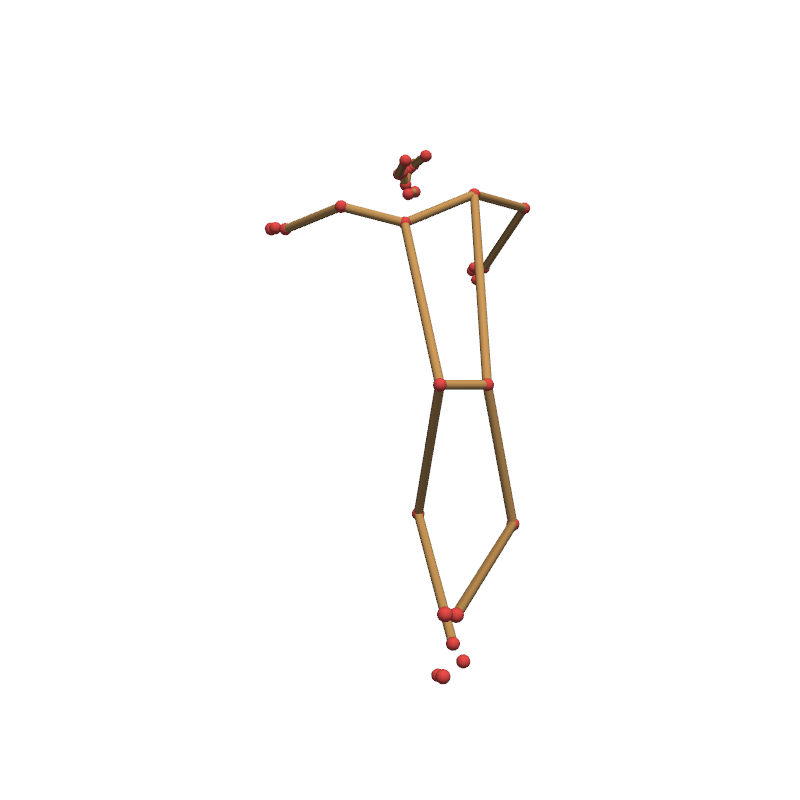

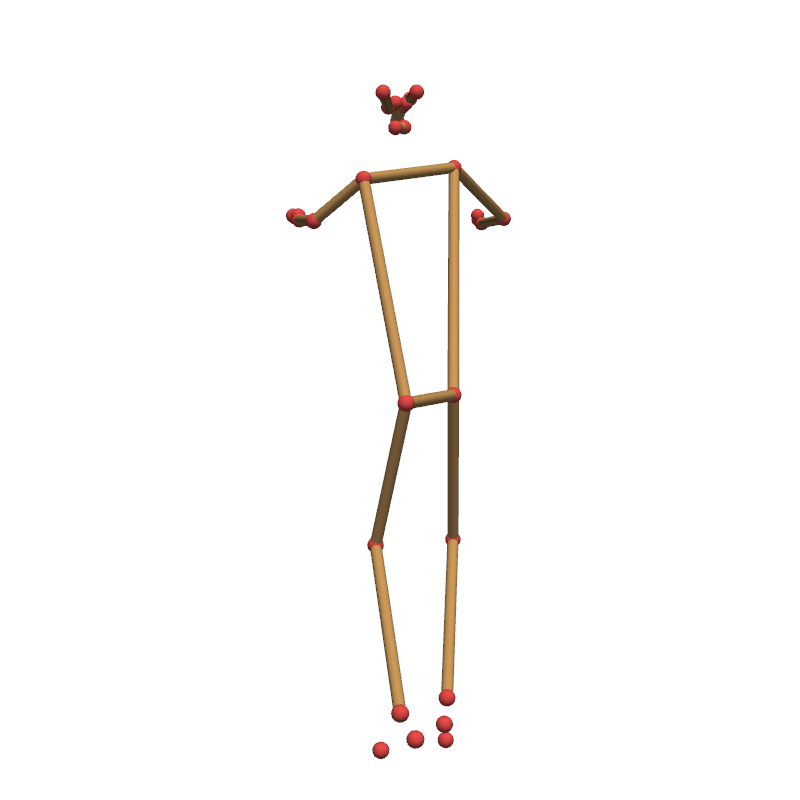


✨ Pipeline execution finished. Check '/content/dance_outputs' for saved model and plots.


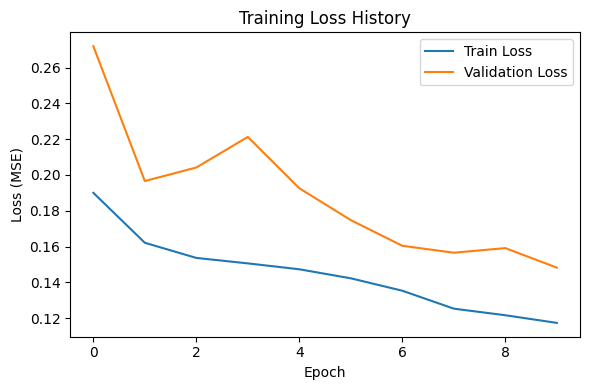

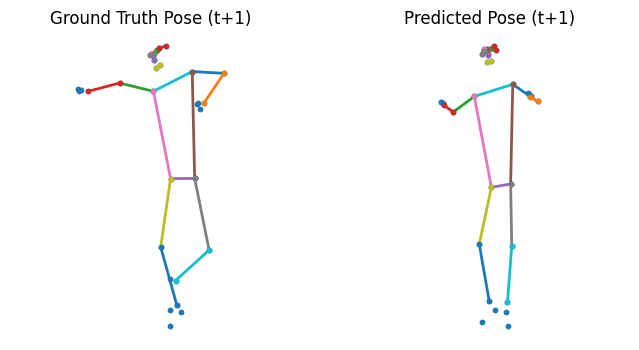

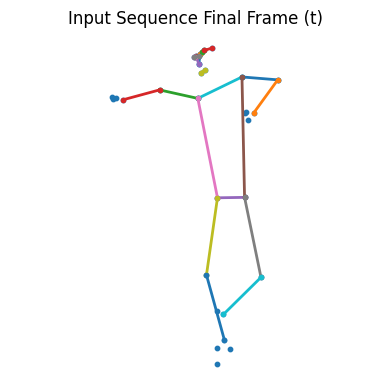

In [ ]:
# Colab-Safe Execution Block
class ColabArgs:
    def __init__(self, drive_path, output_dir, n_videos, epochs, lr):
        self.drive_path = drive_path
        self.output_dir = output_dir
        self.n_videos = n_videos
        self.epochs = epochs
        self.lr = lr

args = ColabArgs(
    drive_path=CFG["drive_videos_dir"],
    output_dir=CFG["output_dir"],
    n_videos=CFG["sample_videos"],
    epochs=CFG["epochs"],
    lr=CFG["lr"]
)

print("Starting ST-GCN Dance Pose Prediction Pipeline (Colab Mode)...")
try:
    main(args)
    print("\n✨ Pipeline execution finished. Check '/content/drive/My Drive/FYP_Extended_Dance_Sequence_Generation/outputs' for saved model and plots.")
except Exception as e:
    print(f"\n❌ An error occurred during pipeline execution: {e}")